In [25]:
import flickrapi

# Replace YOUR_API_KEY and YOUR_API_SECRET with your own credentials
api_key = '60624b0963634d316ccb8a12abdfc644'
api_secret = '3678327259a167f1'
flickr = flickrapi.FlickrAPI(api_key, api_secret, format='parsed-json')

In [26]:
photos = flickr.photos.search(tags='Travel',extras='tags', per_page=20)
total_photos = photos["photos"]["total"]

print(f"Number of travel photos: {total_photos}")

Number of travel photos: 90666


In [3]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
from torch.utils.data import Dataset
import random
from tqdm import tqdm
import json
import threading


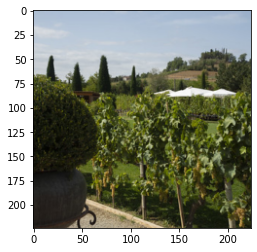

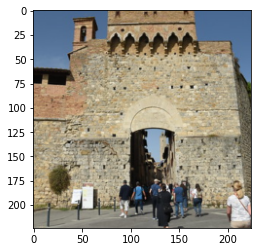

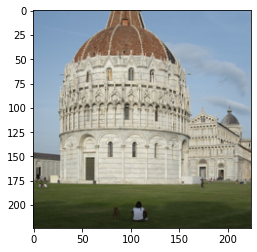

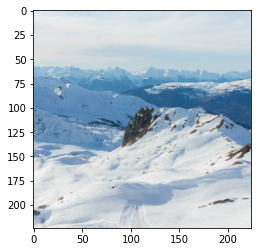

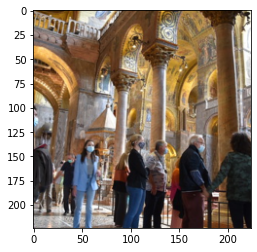

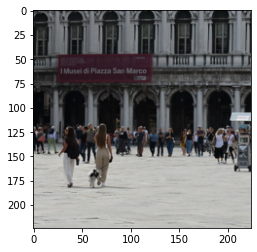

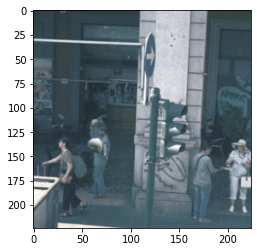

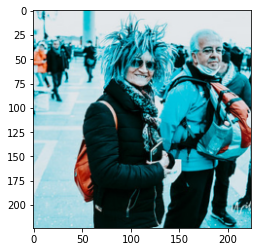

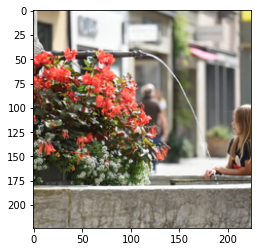

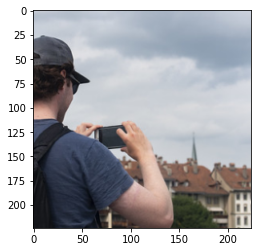

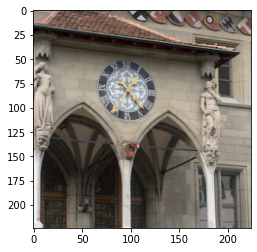

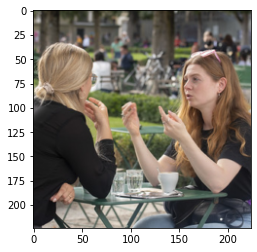

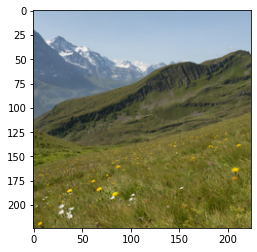

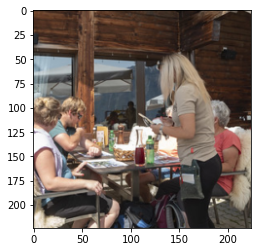

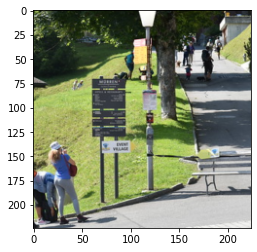

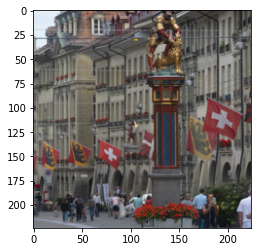

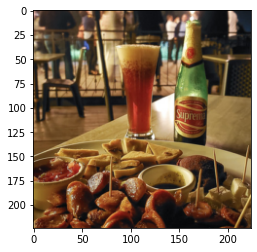

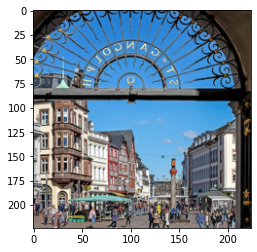

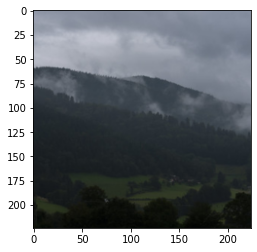

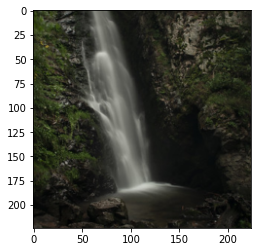

In [27]:
# Define the transformation to apply to the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()]
    )
for photo in photos['photos']['photo']:
    photo_url = 'https://farm{}.staticflickr.com/{}/{}_{}.jpg'.format(photo['farm'], photo['server'], photo['id'], photo['secret'])
    if photo_url:
        response = requests.get(photo_url)
        img = Image.open(BytesIO(response.content))

        # Apply the transformation to the image
        img = transform(img)

        # Display the image
        plt.imshow(img.permute(1, 2, 0))
        plt.show()

In [5]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
from transformers import pipeline
image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning",max_new_tokens=20)

cuda


/home1/08629/pradhakr/.local/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
class FlickrDataset(Dataset):
    def __init__(self, rootdir,data_dir,dataset_type):
        self.root_dir=rootdir
        self.data_dir = data_dir
        self.image_files = sorted(os.listdir(os.path.join(data_dir)))
        if dataset_type=='train':
            self.caption_file = os.path.join(rootdir, "train_captions.txt")
        elif dataset_type=='test':
            self.caption_file = os.path.join(rootdir, "test_captions.txt")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_files[idx])
        tag = ""
        caption = ""
        with open(self.caption_file, "r") as f:
            for line in f:
                parts = line.strip().split("\t")
                if parts[0] == self.image_files[idx]:
                    caption = parts[1]
                    break
        image = Image.open(image_path)
        image = self.transform(image)
        return image, caption

    def transform(self, image):
        transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()]
        )
        return image

In [32]:
dataset = FlickrDataset('data/',"data/train",'train')
print(len(dataset))

4571


a man holding a baby in a zoo costume


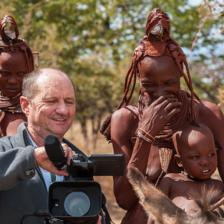

In [35]:
a,b=dataset[3000]
print(b)
a

In [28]:
train_ratio = 1
test_ratio = 0
search_tag='Vacation'
# Specify the number of photos to download
num_photos = 25000

# Initialize a list to store the downloaded photos
downloaded_photos = []

# Make multiple API requests to download the photos
for page in range(1, (num_photos // 500) + 2):
    # Construct the API request URL with the page parameter
    url = "https://www.flickr.com/services/rest/?method=flickr.photos.search&api_key={}&tags={}&per_page=500&page={}&format=json&nojsoncallback=1".format(api_key, search_tag, page)

    # Make the API request and parse the response
    response = requests.get(url,timeout=10)
    response_dict = json.loads(response.content.decode())

    # Extract the photo objects from the response and add them to the downloaded_photos list
    downloaded_photos.extend(response_dict['photos']['photo'])

    # Break the loop if the requested number of photos have been downloaded
    if len(downloaded_photos) >= num_photos:
        break

In [29]:
print(len(downloaded_photos))

25499


In [12]:
output_dir='data/'
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
#os.makedirs(train_dir, exist_ok=True)
#os.makedirs(test_dir, exist_ok=True)

# Create caption files for train and test sets
train_captions_file = os.path.join(output_dir, "train_captions.txt")
test_captions_file = os.path.join(output_dir, "test_captions.txt")
"""with open(train_captions_file, "w") as f:
    pass
with open(test_captions_file, "w") as f:
    pass
"""

'with open(train_captions_file, "w") as f:\n    pass\nwith open(test_captions_file, "w") as f:\n    pass\n'

In [30]:
for photo in tqdm(downloaded_photos[10000:11000]):
    photo_url = 'https://farm{}.staticflickr.com/{}/{}_{}.jpg'.format(photo['farm'], photo['server'], photo['id'], photo['secret'])
    # Create the filename
    filename = "{}_{}.jpg".format(photo['id'], photo['secret'])
    img_path = os.path.join(output_dir, filename)
    
    train_img_path = os.path.join(train_dir, filename)
    test_img_path = os.path.join(test_dir, filename)

    if os.path.exists(train_img_path) or os.path.exists(test_img_path):
        print("Skipping {}, already downloaded".format(filename))
        continue
    
    # Download the image
    response = requests.get(photo_url)
    img1 = Image.open(BytesIO(response.content))
    
    # Apply the transformation to the image
    img = transform(img1)
    # Generate the image caption
    generated_text = image_to_text(photo_url)[0]['generated_text']
    
    # Choose a random number between 0 and 1 to determine which set the image belongs to
    r = random.random()
    if r < train_ratio:
        # Save the image to the train directory
        img_path = os.path.join(train_dir, filename)
        with open(train_captions_file, "a") as f:
            f.write("{}\t{}\n".format(filename, generated_text))
    else:
        # Save the image to the test directory
        img_path = os.path.join(test_dir, filename)
        with open(test_captions_file, "a") as f:
            f.write("{}\t{}\n".format(filename, generated_text))
    
    try:
        torchvision.utils.save_image(img, img_path)
    except FileNotFoundError as e:
        print("Error: File not found: {}".format(e))
        continue


  4%|▍         | 43/1000 [01:49<43:03,  2.70s/it]

Skipping 52719453797_d107b88000.jpg, already downloaded
Skipping 52720396505_62522ddea2.jpg, already downloaded
Skipping 52720241644_80435cf429.jpg, already downloaded
Skipping 52720241509_63376d58bb.jpg, already downloaded
Skipping 52720352475_182f617751.jpg, already downloaded
Skipping 52720038734_c2bf9b173e.jpg, already downloaded
Skipping 52719770481_4c5f72fd0b.jpg, already downloaded
Skipping 52719763806_da4a73f9e4.jpg, already downloaded
Skipping 52719747246_b62bf0c3a5.jpg, already downloaded
Skipping 52720228848_c10f9579d1.jpg, already downloaded
Skipping 52718815312_204385b4f2.jpg, already downloaded


  6%|▌         | 56/1000 [01:54<12:15,  1.28it/s]

Skipping 52719599099_26e8efa7dd.jpg, already downloaded


  6%|▌         | 59/1000 [01:58<15:42,  1.00s/it]

Skipping 52719597744_38486be942.jpg, already downloaded
Skipping 52719597059_88d1101014.jpg, already downloaded
Skipping 52718812242_99e3c8288c.jpg, already downloaded
Skipping 52718123484_34e3835ffc.jpg, already downloaded
Skipping 52718123089_2681e80394.jpg, already downloaded


  6%|▋         | 65/1000 [02:00<10:38,  1.46it/s]

Skipping 52717783841_e58f75618c.jpg, already downloaded


  7%|▋         | 68/1000 [02:04<14:36,  1.06it/s]

Skipping 52718051284_423d1f22ca.jpg, already downloaded
Skipping 52718051209_12948343b3.jpg, already downloaded
Skipping 52718050864_6051276a30.jpg, already downloaded
Skipping 52717072067_683f90ca29.jpg, already downloaded
Skipping 52717782749_b89a9f80e7.jpg, already downloaded
Skipping 52717516005_9a9fcdb101.jpg, already downloaded
Skipping 52716467502_3f31e1a9ca.jpg, already downloaded
Skipping 52716768289_17580f3eba.jpg, already downloaded
Skipping 52715915357_9c80c26953.jpg, already downloaded
Skipping 52716725300_7a267137f3.jpg, already downloaded
Skipping 52716269945_4bb77c93e4.jpg, already downloaded
Skipping 52715303447_3862dc2b39.jpg, already downloaded
Skipping 52714669717_f4c88c64e7.jpg, already downloaded


  8%|▊         | 82/1000 [02:07<06:00,  2.55it/s]

Skipping 52715249005_86a69e083a.jpg, already downloaded
Skipping 52714764371_48ff0cce8e.jpg, already downloaded


  8%|▊         | 85/1000 [02:09<06:33,  2.32it/s]

Skipping 52714530655_6d9fae9c21.jpg, already downloaded
Skipping 52714110991_21c882a3c3.jpg, already downloaded


  9%|▉         | 88/1000 [02:11<07:32,  2.02it/s]

Skipping 52713585172_6ff90ab920.jpg, already downloaded
Skipping 52714529015_9d8ff29f34.jpg, already downloaded


  9%|▉         | 92/1000 [02:15<10:25,  1.45it/s]

Skipping 52714366089_8869e0f87d.jpg, already downloaded


  9%|▉         | 94/1000 [02:17<11:42,  1.29it/s]

Skipping 52714578998_92cab12b46.jpg, already downloaded
Skipping 52714363514_b7ce0a8e7a.jpg, already downloaded
Skipping 52714524920_bc320117c2.jpg, already downloaded
Skipping 52714577778_7e09a32062.jpg, already downloaded
Skipping 52713911290_3ca7bb6f4e.jpg, already downloaded
Skipping 52713910140_8c3de767c9.jpg, already downloaded
Skipping 52713494311_b5b0010964.jpg, already downloaded
Skipping 52713970038_6a35929329.jpg, already downloaded
Skipping 52713691823_842b14b026.jpg, already downloaded


 10%|█         | 104/1000 [02:20<06:53,  2.16it/s]

Skipping 52713715648_933dc6cf6d.jpg, already downloaded
Skipping 52713182906_79b6ee2dc1.jpg, already downloaded
Skipping 52712657837_4940e87f72.jpg, already downloaded
Skipping 52712654727_eb702fdd88.jpg, already downloaded
Skipping 52713639773_889edb0886.jpg, already downloaded
Skipping 52713417214_8445439b7f.jpg, already downloaded
Skipping 52711866139_3af2feb2a1.jpg, already downloaded
Skipping 52712080318_a2f1643cc9.jpg, already downloaded
Skipping 52711601316_e49d2105b5.jpg, already downloaded
Skipping 52711076867_408d4a4295.jpg, already downloaded
Skipping 52711592336_6daf2c8a5e.jpg, already downloaded
Skipping 52711986410_11e5c8f2e0.jpg, already downloaded
Skipping 52711828374_6d877400ab.jpg, already downloaded
Skipping 52711827449_7d553933ea.jpg, already downloaded
Skipping 52710859992_61a90469e7.jpg, already downloaded


 12%|█▏        | 121/1000 [02:25<05:41,  2.58it/s]

Skipping 52710575153_b93868eb50.jpg, already downloaded
Skipping 52710093586_5fc8cd336d.jpg, already downloaded
Skipping 52710093431_b4e0d66870.jpg, already downloaded
Skipping 52709573122_11ea9a530f.jpg, already downloaded
Skipping 52709566087_fd47cea7f0.jpg, already downloaded
Skipping 52710565593_ce2aeaa5c9.jpg, already downloaded


 13%|█▎        | 128/1000 [02:28<05:55,  2.45it/s]

Skipping 52710544573_a576851a12.jpg, already downloaded


 13%|█▎        | 130/1000 [02:30<07:02,  2.06it/s]

Skipping 52709740681_4923f6f09e.jpg, already downloaded
Skipping 52710002464_d70b52e644.jpg, already downloaded
Skipping 52710154860_b1f30c0ddf.jpg, already downloaded


 13%|█▎        | 134/1000 [02:32<07:00,  2.06it/s]

Skipping 52709931908_78f6ae4c25.jpg, already downloaded
Skipping 52709814920_bb3a3259b8.jpg, already downloaded


 14%|█▎        | 137/1000 [02:34<07:38,  1.88it/s]

Skipping 52709685305_ec9460a370.jpg, already downloaded
Skipping 52709179206_ba007f9201.jpg, already downloaded


 14%|█▍        | 140/1000 [02:37<08:42,  1.65it/s]

Skipping 52709331245_ecdfa95f7f.jpg, already downloaded


 14%|█▍        | 143/1000 [02:41<12:39,  1.13it/s]

Skipping 52709400438_f67b469847.jpg, already downloaded
Skipping 52708916851_78ba15339e.jpg, already downloaded
Skipping 52709170559_59c501623e.jpg, already downloaded


 15%|█▍        | 147/1000 [02:44<11:00,  1.29it/s]

Skipping 52708916031_cbc4fa1288.jpg, already downloaded
Skipping 52709398398_496ddcbf15.jpg, already downloaded
Skipping 52709325975_212d1aac45.jpg, already downloaded
Skipping 52708387562_10c4143bcd.jpg, already downloaded
Skipping 52709324775_b8f108f10b.jpg, already downloaded
Skipping 52709165999_ecaeab9084.jpg, already downloaded
Skipping 52709324445_4f086481b1.jpg, already downloaded
Skipping 52709394928_9deaf48357.jpg, already downloaded
Skipping 52709394423_6d66e8b251.jpg, already downloaded
Skipping 52708910486_27c3ab780d.jpg, already downloaded
Skipping 52709164579_c3b577e2ef.jpg, already downloaded


 16%|█▌        | 159/1000 [02:46<05:44,  2.44it/s]

Skipping 52709392908_b16cdfe731.jpg, already downloaded
Skipping 52709392648_75e04e22e7.jpg, already downloaded


 16%|█▋        | 165/1000 [02:57<15:19,  1.10s/it]

Skipping 52708379322_ab341bbe2b.jpg, already downloaded
Skipping 52708885264_84310833eb.jpg, already downloaded


 17%|█▋        | 168/1000 [02:59<13:43,  1.01it/s]

Skipping 52707782437_a4fc3eb2ea.jpg, already downloaded
Skipping 46074524295_7656066e4a.jpg, already downloaded


 17%|█▋        | 171/1000 [03:01<12:20,  1.12it/s]

Skipping 52708518708_7b91ba1337.jpg, already downloaded
Skipping 52707117907_0c6fd66b6d.jpg, already downloaded


 17%|█▋        | 174/1000 [03:04<11:47,  1.17it/s]

Skipping 52707269734_b7668a615c.jpg, already downloaded
Skipping 52707192314_2f30428aff.jpg, already downloaded


 18%|█▊        | 178/1000 [03:08<13:33,  1.01it/s]

Skipping 52706927606_5e6a44c4ec.jpg, already downloaded
Skipping 52706291387_bfc5024f97.jpg, already downloaded
Skipping 52706394329_9069b14706.jpg, already downloaded


 18%|█▊        | 183/1000 [03:12<13:27,  1.01it/s]

Skipping 52705047943_3a6bbdff7d.jpg, already downloaded


 19%|█▊        | 186/1000 [03:17<16:57,  1.25s/it]

Skipping 52704501691_164d8a03af.jpg, already downloaded


 19%|█▉        | 188/1000 [03:22<22:12,  1.64s/it]

Skipping 52704296476_e7a1f291e6.jpg, already downloaded
Skipping 52704783148_c65d065c56.jpg, already downloaded
Skipping 52704405459_ed548f75a6.jpg, already downloaded


 19%|█▉        | 192/1000 [03:26<17:50,  1.32s/it]

Skipping 52704150646_6d4d7d08b7.jpg, already downloaded


 19%|█▉        | 194/1000 [03:28<16:48,  1.25s/it]

Skipping 52704570215_b016451199.jpg, already downloaded


 20%|█▉        | 196/1000 [03:32<19:25,  1.45s/it]

Skipping 52704002430_dd9caed107.jpg, already downloaded


 20%|█▉        | 199/1000 [03:36<18:32,  1.39s/it]

Skipping 52703059072_b288a901e8.jpg, already downloaded


 20%|██        | 200/1000 [03:38<19:51,  1.49s/it]

Skipping 52703307878_bb18256106.jpg, already downloaded
Skipping 52701931311_9c1695137f.jpg, already downloaded


 20%|██        | 205/1000 [03:46<22:54,  1.73s/it]

Skipping 52702198675_fbd018a915.jpg, already downloaded


 21%|██▏       | 213/1000 [03:50<08:28,  1.55it/s]

Skipping 52701998363_4d9b395294.jpg, already downloaded
Skipping 52701998343_1826492ac8.jpg, already downloaded
Skipping 52700988427_328f024efd.jpg, already downloaded
Skipping 52700988207_fa7bdf1edc.jpg, already downloaded
Skipping 52700988157_5d578dfe18.jpg, already downloaded
Skipping 52701763889_dbcf537ecc.jpg, already downloaded


 22%|██▏       | 215/1000 [03:55<14:31,  1.11s/it]

Skipping 52701324979_32a4976bf2.jpg, already downloaded


 22%|██▏       | 218/1000 [03:58<12:49,  1.02it/s]

Skipping 52700702665_c15604bf49.jpg, already downloaded


 22%|██▏       | 220/1000 [04:00<13:52,  1.07s/it]

Skipping 52700279241_8bef11f037.jpg, already downloaded
Skipping 52700537610_b800c1df4e.jpg, already downloaded


 22%|██▏       | 224/1000 [04:08<21:23,  1.65s/it]

Skipping 52699015907_e639ae386b.jpg, already downloaded
Skipping 52699794689_9289e2bcbb.jpg, already downloaded


 23%|██▎       | 228/1000 [04:17<26:38,  2.07s/it]

Skipping 52699765939_512148a61a.jpg, already downloaded
Skipping 52698967307_24020baa7c.jpg, already downloaded
Skipping 52699747194_395a3dff33.jpg, already downloaded


 23%|██▎       | 232/1000 [04:19<16:14,  1.27s/it]

Skipping 52698930097_3e8799d82f.jpg, already downloaded
Skipping 52698097676_4695d99f91.jpg, already downloaded


 24%|██▎       | 236/1000 [04:25<18:09,  1.43s/it]

Skipping 52697568947_a10d97f6b5.jpg, already downloaded
Skipping 52698575828_d8d5844fb5.jpg, already downloaded


 24%|██▍       | 244/1000 [04:38<24:38,  1.96s/it]

Skipping 52698379780_2dba5d59bc.jpg, already downloaded
Skipping 52698347220_26cefc4df8.jpg, already downloaded
Skipping 52697174327_e15ba5e08b.jpg, already downloaded


 25%|██▍       | 248/1000 [04:41<14:33,  1.16s/it]

Skipping 52697727889_d65c5a1842.jpg, already downloaded


 25%|██▌       | 251/1000 [04:46<18:14,  1.46s/it]

Skipping 52696998133_785312509b.jpg, already downloaded
Skipping 52696772034_89847cda76.jpg, already downloaded
Skipping 52696927340_d938078262.jpg, already downloaded
Skipping 52696700629_56493e00af.jpg, already downloaded


 26%|██▌       | 257/1000 [04:51<14:04,  1.14s/it]

Skipping 52696172191_b87a7a400d.jpg, already downloaded


 26%|██▌       | 259/1000 [04:53<14:05,  1.14s/it]

Skipping 52695632252_4dfd3dfb16.jpg, already downloaded


 26%|██▌       | 261/1000 [04:56<14:16,  1.16s/it]

Skipping 52696636658_9b9ec08673.jpg, already downloaded
Skipping 52696446588_bb31170eee.jpg, already downloaded
Skipping 52695919496_0f6b121d05.jpg, already downloaded


 26%|██▋       | 265/1000 [04:58<10:16,  1.19it/s]

Skipping 52695955465_71a3810ce9.jpg, already downloaded


 27%|██▋       | 268/1000 [05:02<12:42,  1.04s/it]

Skipping 52694602602_e452924db1.jpg, already downloaded


 27%|██▋       | 270/1000 [05:04<13:29,  1.11s/it]

Skipping 52695358309_0910b0c7fc.jpg, already downloaded
Skipping 52695337644_2f5f622e01.jpg, already downloaded


 27%|██▋       | 274/1000 [05:08<13:33,  1.12s/it]

Skipping 52695063315_4ef8fc7391.jpg, already downloaded


 28%|██▊       | 276/1000 [05:11<13:55,  1.15s/it]

Skipping 52694884974_826f7aa7f0.jpg, already downloaded
Skipping 52695070288_cc4ee49eb1.jpg, already downloaded
Skipping 52694844624_c7b0db5a46.jpg, already downloaded
Skipping 52694844559_1ebab0a1e9.jpg, already downloaded


 28%|██▊       | 282/1000 [05:16<12:06,  1.01s/it]

Skipping 52694062397_d6c2ae4cca.jpg, already downloaded
Skipping 52695068958_f050fa572c.jpg, already downloaded
Skipping 52694051912_442399efee.jpg, already downloaded
Skipping 52694051667_a2cf30a71c.jpg, already downloaded
Skipping 52693569602_cf5ebca692.jpg, already downloaded


 29%|██▉       | 288/1000 [05:18<08:03,  1.47it/s]

Skipping 52693290531_5fd3e718b8.jpg, already downloaded
Skipping 52693778518_4fa944758e.jpg, already downloaded


 29%|██▉       | 291/1000 [05:20<08:17,  1.42it/s]

Skipping 52693288126_1b3d14d8a1.jpg, already downloaded


 30%|██▉       | 296/1000 [05:30<17:37,  1.50s/it]

Skipping 52693537640_acfaa7ae9f.jpg, already downloaded
Skipping 52692570772_c4ed05993d.jpg, already downloaded
Skipping 52693498965_d9eca4b593.jpg, already downloaded
Skipping 52692735322_9d93475e4e.jpg, already downloaded
Skipping 52693662300_4b6ccb589e.jpg, already downloaded


 30%|███       | 303/1000 [05:34<11:13,  1.03it/s]

Skipping 52693503744_27963fcdbf.jpg, already downloaded


 31%|███       | 308/1000 [05:44<19:51,  1.72s/it]

Skipping 52693233196_59781d238f.jpg, already downloaded


 31%|███       | 310/1000 [05:47<18:46,  1.63s/it]

Skipping 52693721653_f6d0d66d54.jpg, already downloaded


 31%|███▏      | 313/1000 [05:52<19:19,  1.69s/it]

Skipping 52692712327_e04b7a61c2.jpg, already downloaded


 32%|███▏      | 315/1000 [05:54<17:02,  1.49s/it]

Skipping 52693230161_81987abed6.jpg, already downloaded


 32%|███▏      | 317/1000 [05:57<15:56,  1.40s/it]

Skipping 52693718163_a1e8999a63.jpg, already downloaded


 32%|███▏      | 320/1000 [06:02<17:08,  1.51s/it]

Skipping 52693716863_2b6503a840.jpg, already downloaded
Skipping 52693636560_ac89442596.jpg, already downloaded
Skipping 52693494144_fd8177cf38.jpg, already downloaded
Skipping 52692708322_0dd3d5d881.jpg, already downloaded
Skipping 52692708257_9f26f740b9.jpg, already downloaded
Skipping 52693493724_7835cb2a8e.jpg, already downloaded
Skipping 52692707997_a70557a0bc.jpg, already downloaded
Skipping 52693715078_7cfb2318cb.jpg, already downloaded


 33%|███▎      | 330/1000 [06:07<09:18,  1.20it/s]

Skipping 52693492674_412e71516c.jpg, already downloaded


 33%|███▎      | 332/1000 [06:09<10:22,  1.07it/s]

Skipping 52693634645_6554d72f9a.jpg, already downloaded
Skipping 52693224011_ca4de59c90.jpg, already downloaded


 34%|███▎      | 337/1000 [06:15<12:24,  1.12s/it]

Skipping 52691925843_8c04224c9f.jpg, already downloaded


 34%|███▍      | 339/1000 [06:18<12:54,  1.17s/it]

Skipping 52691852200_467502d0c8.jpg, already downloaded
Skipping 52691925198_74a3c01590.jpg, already downloaded
Skipping 52691435061_62a9d29217.jpg, already downloaded
Skipping 52691434181_e3ec673963.jpg, already downloaded
Skipping 52690914402_1e80bda16c.jpg, already downloaded
Skipping 52690914182_0cc8fd54e3.jpg, already downloaded


 35%|███▍      | 349/1000 [06:27<13:28,  1.24s/it]

Skipping 52691923128_1c16381255.jpg, already downloaded


 35%|███▌      | 351/1000 [06:29<12:39,  1.17s/it]

Skipping 52691432496_2b75613864.jpg, already downloaded


 35%|███▌      | 353/1000 [06:31<12:56,  1.20s/it]

Skipping 52691848090_36c75cd876.jpg, already downloaded


 36%|███▌      | 355/1000 [06:34<12:55,  1.20s/it]

Skipping 52691847060_229fa71da0.jpg, already downloaded


 36%|███▌      | 357/1000 [06:36<13:05,  1.22s/it]

Skipping 52691920328_8ea570c7dc.jpg, already downloaded
Skipping 52691699224_879e21e822.jpg, already downloaded
Skipping 52691919013_f39c4bbf9e.jpg, already downloaded


 36%|███▋      | 363/1000 [06:43<13:50,  1.30s/it]

Skipping 52691428061_028b5dc6e5.jpg, already downloaded


 37%|███▋      | 366/1000 [06:47<14:23,  1.36s/it]

Skipping 52691697369_d7c443ea33.jpg, already downloaded
Skipping 52691916338_6d4016388c.jpg, already downloaded


 37%|███▋      | 369/1000 [06:50<11:59,  1.14s/it]

Skipping 52691426166_d1d05cd69d.jpg, already downloaded


 37%|███▋      | 371/1000 [06:53<12:26,  1.19s/it]

Skipping 52691913533_8066f0db2c.jpg, already downloaded


 38%|███▊      | 378/1000 [07:08<22:59,  2.22s/it]

Skipping 52691691124_2eafca7a85.jpg, already downloaded


 38%|███▊      | 380/1000 [07:10<18:01,  1.74s/it]

Skipping 52690898282_bab43a3399.jpg, already downloaded


 38%|███▊      | 383/1000 [07:16<19:14,  1.87s/it]

Skipping 52691906783_1746511745.jpg, already downloaded


 38%|███▊      | 385/1000 [07:18<16:19,  1.59s/it]

Skipping 52691831725_e717943ae4.jpg, already downloaded


 39%|███▊      | 387/1000 [07:20<14:41,  1.44s/it]

Skipping 52691411511_c072aa4cc6.jpg, already downloaded


 39%|███▉      | 389/1000 [07:23<13:53,  1.36s/it]

Skipping 52691826415_793c4dbb34.jpg, already downloaded
Skipping 52690637447_e0a1546f86.jpg, already downloaded


 39%|███▉      | 393/1000 [07:27<13:00,  1.29s/it]

Skipping 52689492137_64ce95239a.jpg, already downloaded


 40%|███▉      | 396/1000 [07:32<14:51,  1.48s/it]

Skipping 52689527571_b2f0818876.jpg, already downloaded
Skipping 52690017468_ec2ffddd7f.jpg, already downloaded


 40%|████      | 402/1000 [07:42<17:25,  1.75s/it]

Skipping 52689942685_9b1eee7ec3.jpg, already downloaded


 41%|████      | 406/1000 [07:49<19:12,  1.94s/it]

Skipping 52689039814_66e297f172.jpg, already downloaded
Skipping 52689299010_64837abc49.jpg, already downloaded
Skipping 52689298070_ce813df237.jpg, already downloaded


 41%|████▏     | 413/1000 [07:57<14:40,  1.50s/it]

Skipping 52687972295_6795990903.jpg, already downloaded
Skipping 52688041478_990e212e84.jpg, already downloaded


 42%|████▏     | 416/1000 [08:00<12:01,  1.23s/it]

Skipping 52688039003_858d811122.jpg, already downloaded


 42%|████▏     | 421/1000 [08:09<17:38,  1.83s/it]

Skipping 52687963860_073b1a752e.jpg, already downloaded


 42%|████▎     | 425/1000 [08:14<11:08,  1.16s/it]

Skipping 52687817754_53a318c3bb.jpg, already downloaded


ConnectionError: HTTPSConnectionPool(host='farm0.staticflickr.com', port=443): Max retries exceeded with url: /0/52687013337_945e761980.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x2b7533e6ca60>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [36]:
import zipfile

output_filename = "data.zip"

with zipfile.ZipFile(output_filename, "w") as zip_file:
    # Add the train directory and all its contents to the zip file
    for root, dirs, files in os.walk(train_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zip_file.write(file_path, os.path.relpath(file_path, train_dir))

    # Add the test directory and all its contents to the zip file
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zip_file.write(file_path, os.path.relpath(file_path, test_dir))

    # Add the train and test captions files to the zip file
    zip_file.write(train_captions_file, os.path.basename(train_captions_file))
    zip_file.write(test_captions_file, os.path.basename(test_captions_file))